### Echoes datasets: International Survey - Feature Importance
* Data surveys: 
    * energy provider survey
    * international survey:
        * Demographic questions (stratification?)
        * WP7 questions (scenarios, ...)
        * WP4 questions (intents, beliefs, ...)
        * WP5 questions (energy efficiency: daily routine, ...)
* Decision Tree/Random Forest:
    * 1. feat. importance
    * 2. feat. selection
* Classification/Regression

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utest")

from parseSurvey import SurveyConditioning
from plotFeatures import BubbleChart

import sklearn
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import (cross_validate, 
                                     cross_val_score, 
                                     StratifiedKFold, 
                                     KFold,
                                     train_test_split,
                                     StratifiedShuffleSplit)
                                     
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [11]:
sheet = pd.read_csv('ECHOES_raw_data_int_survey.csv', sep=',', decimal=',', low_memory=False)
survey_codebook = pd.read_excel('ECHOES_Main_survey_codebook.xlsx', header=0, usecols=['Shortvariablename',
                                                                                       'SPSS Variable name',
                                                                                       'Question'])
survey_appendix = pd.read_excel('ECHOES_int_survey_appendix.xlsx', header=0)

In [12]:
# remove last two columns in sheet [expRevealed, Q114] and Q6e_1
drop_cols = ['expRevealed', 'Q114', 'Q6e_1']
sheet.drop(drop_cols, axis=1, inplace=True)

In [13]:
survey_appendix

,Choice situation,a.rate,a.hold,a.tech,a.loc,a.admin,b.rate,b.hold,b.tech,b.loc,b.admin,Block
0,5,5,5,0,1,2,50,15,0,1,2,1
1,6,10,5,1,1,0,20,10,1,0,1,1
2,10,20,10,1,1,0,0,15,1,0,0,1
3,11,0,15,0,1,2,20,10,0,0,2,1
4,12,50,5,0,0,1,20,5,0,1,1,1
5,15,5,15,1,0,0,5,5,1,0,1,1
6,16,20,10,1,0,2,50,15,1,1,1,1
7,24,0,10,0,0,1,10,15,0,1,0,1
8,2,5,5,0,0,1,20,5,0,0,1,2
9,4,5,10,1,0,0,5,5,1,0,2,2


In [14]:
display(sheet.head())
display(sheet.shape)
display(survey_codebook.head())
display(survey_codebook.shape)

,ID,country_sample,age,gender,employment,rural,current_address,zip,nationality,number_residents,...,Q104,Q105,Q106,Q107,Q108,Q109,Q110,Q111,Q112,Q113
0,20581001,1,5,2,4,2,4,2851,1,2,...,2,3,4,7,2,NaN,1,1,2,3
1,252001,1,3,1,1,2,1,8844,1,3,...,3,2,1,7,1,2.0,4,2,2,4
2,28539001,1,2,1,1,2,2,8113,1,6,...,3,5,2,1,2,NaN,2,1,1,2
3,2784001,1,4,1,1,2,1,6571,1,4,...,2,3,2,6,1,2.0,4,3,2,5
4,1441001,1,2,1,7,2,1,5300,23,3,...,3,5,6,1,1,2.0,4,1,2,4


(18037, 421)

,Shortvariablename,SPSS Variable name,Question
0,country_sample,Q0_country_sample,Which country sample is this respondant a part...
1,age,Q1_age,How old are you ?
2,gender,Q2_gender,Please indicate your gender
3,employment,Q3_employment,Which of the following best describes you?
4,rural,Q4_rural,Which of the following best describes where yo...


(281, 3)

In [15]:
sheet

,ID,country_sample,age,gender,employment,rural,current_address,zip,nationality,number_residents,...,Q104,Q105,Q106,Q107,Q108,Q109,Q110,Q111,Q112,Q113
0,20581001,1,5,2,4,2,4,2851,1,2,...,2,3,4,7,2,NaN,1,1,2,3
1,252001,1,3,1,1,2,1,8844,1,3,...,3,2,1,7,1,2.0,4,2,2,4
2,28539001,1,2,1,1,2,2,8113,1,6,...,3,5,2,1,2,NaN,2,1,1,2
3,2784001,1,4,1,1,2,1,6571,1,4,...,2,3,2,6,1,2.0,4,3,2,5
4,1441001,1,2,1,7,2,1,5300,23,3,...,3,5,6,1,1,2.0,4,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18032,1978031,31,3,2,1,1,4,0,28,2,...,3,2,2,4,1,2.0,1,4,2,4
18033,2021031,31,2,1,1,2,1,0,28,2,...,3,3,1,4,1,1.0,3,3,3,4
18034,2209031,31,2,2,1,1,4,0,28,5,...,2,5,1,4,1,3.0,2,3,2,2
18035,2214031,31,2,2,1,1,1,0,28,2,...,1,3,3,4,1,2.0,2,1,2,3


In [16]:
survey_codebook['SPSS Variable name'] = survey_codebook['SPSS Variable name'].astype(str)
survey_codebook['Shortvariablename'] = survey_codebook['Shortvariablename'].astype(str)
survey_codebook['SPSS Variable name'].dtype

dtype('O')

In [17]:
# 'SPSS Variable name'
label2question = survey_codebook.set_index('Shortvariablename')['Question'].to_dict()
label2question

{'country_sample': 'Which country sample is this respondant a part of?',
 'age': 'How old are you\xa0? ',
 'gender': 'Please indicate your gender',
 'employment': 'Which of the following best describes you? ',
 'rural': 'Which of the following best describes where you live?',
 'current_address': 'For approximately how many years have you been living at your current address? ',
 'zip': 'Please provide your postal code (ZIP code)',
 'nationality': 'Which nationality were you born with?',
 'number_residents': 'How many people currently live in your household, including yourself?',
 'children': 'How many children do you have?',
 'under_14': 'How many of your children are under the age of 14?',
 'education': 'Which of the following is your highest level of education? ',
 'social_status': 'Where would you place yourself on this ladder?',
 'economic_outlook': 'How would you describe your political outlook with regard to economic issues (e.g. taxes, cooperative vs. protective foreign economic 

In [18]:
sheet_cols = sheet.columns.tolist()
sheet_cols

['ID',
 'country_sample',
 'age',
 'gender',
 'employment',
 'rural',
 'current_address',
 'zip',
 'nationality',
 'number_residents',
 'children',
 'under_14',
 'education',
 'social_status',
 'economic_outlook',
 'social_outlook',
 'median_income',
 'Firstquartile_income',
 'Thirdquartile_income',
 'Ninetieth_income',
 'income',
 'income_a',
 'income_b',
 'income_c',
 'bVscenariosRES',
 'gScenarios',
 'gWP4',
 'pWP4',
 'scenBlock',
 'Sc_ID_1',
 'choice_1_1',
 'choice_1_2',
 'choice_1_3',
 'optA_rate_1_1',
 'optA_rate_1_2',
 'optA_rate_1_3',
 'optA_rate_1_4',
 'optA_rate_1_5',
 'optA_rate_1_6',
 'optA_hold_1_1',
 'optA_hold_1_2',
 'optA_hold_1_3',
 'optA_tech_1_1',
 'optA_tech_1_2',
 'optA_loc_1_1',
 'optA_loc_1_2',
 'optA_admin_1_1',
 'optA_admin_1_2',
 'optA_admin_1_3',
 'optB_rate_1_1',
 'optB_rate_1_2',
 'optB_rate_1_3',
 'optB_rate_1_4',
 'optB_rate_1_5',
 'optB_rate_1_6',
 'optB_hold_1_1',
 'optB_hold_1_2',
 'optB_hold_1_3',
 'optB_tech_1_1',
 'optB_tech_1_2',
 'optB_loc_1_1',
 

In [19]:
import re

def onehot2label_encoding(df, column_names):
    # Sanity check
    assert df[column_names].sum(axis=1).all(), f"All rows do not sum to 1: {df[column_names].dtypes}"
    
    # Convert to label encoding
    new_col = '_'.join((column_names[0].split('_')[:-1]))
    new_idx = df.columns.get_loc(column_names[-1])

    df.insert(new_idx+1, new_col, df[column_names].values.argmax(1)+1)
    df.drop(column_names, axis=1, inplace=True)
    
    return df

def filter_users(df, column_names):
    one_hot_sum = df[column_names].sum(axis=1)
    remove_users = one_hot_sum[one_hot_sum == 0].index
    df.drop(remove_users, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df
    

# Create one-hot encoded groups to be merged later
onehot_encoded_groups = []
keywords = ['rate', 'hold', 'tech', 'loc', 'admin']
for scenario_id in range(1, 9):
    choices = [f"choice_{scenario_id}_{i}" for i in [1, 2, 3]]
    onehot_encoded_groups.append(choices)
    
    for option in ['A', 'B']:
        for keyword in keywords:
            r = re.compile(f"opt{option}_{keyword}_{scenario_id}")
            column_names = list(filter(r.match, sheet_cols))
            onehot_encoded_groups.append(column_names)

onehot_encoded_groups

[['choice_1_1', 'choice_1_2', 'choice_1_3'],
 ['optA_rate_1_1',
  'optA_rate_1_2',
  'optA_rate_1_3',
  'optA_rate_1_4',
  'optA_rate_1_5',
  'optA_rate_1_6'],
 ['optA_hold_1_1', 'optA_hold_1_2', 'optA_hold_1_3'],
 ['optA_tech_1_1', 'optA_tech_1_2'],
 ['optA_loc_1_1', 'optA_loc_1_2'],
 ['optA_admin_1_1', 'optA_admin_1_2', 'optA_admin_1_3'],
 ['optB_rate_1_1',
  'optB_rate_1_2',
  'optB_rate_1_3',
  'optB_rate_1_4',
  'optB_rate_1_5',
  'optB_rate_1_6'],
 ['optB_hold_1_1', 'optB_hold_1_2', 'optB_hold_1_3'],
 ['optB_tech_1_1', 'optB_tech_1_2'],
 ['optB_loc_1_1', 'optB_loc_1_2'],
 ['optB_admin_1_1', 'optB_admin_1_2', 'optB_admin_1_3'],
 ['choice_2_1', 'choice_2_2', 'choice_2_3'],
 ['optA_rate_2_1',
  'optA_rate_2_2',
  'optA_rate_2_3',
  'optA_rate_2_4',
  'optA_rate_2_5',
  'optA_rate_2_6'],
 ['optA_hold_2_1', 'optA_hold_2_2', 'optA_hold_2_3'],
 ['optA_tech_2_1', 'optA_tech_2_2'],
 ['optA_loc_2_1', 'optA_loc_2_2'],
 ['optA_admin_2_1', 'optA_admin_2_2', 'optA_admin_2_3'],
 ['optB_rate_2_1

In [20]:
# Filter/remove users where columns are 0
print(len(sheet))

for cols in onehot_encoded_groups:
    sheet = filter_users(sheet, cols)
    
print(len(sheet))

18037
17829


In [21]:
# Merge one-hot-encoded columns
for cols in onehot_encoded_groups:
    sheet = onehot2label_encoding(sheet, cols)

In [22]:
sheet_cols = sheet.columns.tolist()

### Map features to questions:

In [23]:
feat2quest = survey_codebook.copy()

In [24]:
# Parser
# 1. Filter out matches
# 2. Map scenarios
# 3. Map questions

def set_question(df, codebook_col, codebook_kw):
    question = df[df[codebook_col] == codebook_kw]['Question'].values[0]
    return question

def parse_scenarios(df):
    mapping = {}
    keywords = ['rate', 'hold', 'tech', 'loc', 'admin']
    for scenario_id in range(1, 9):
        mapping[f"Sc_ID_{scenario_id}"] = set_question(df, 'Shortvariablename', f"Sc{scenario_id}_ID")
        
        choice_question = set_question(df, 'Shortvariablename', f"choice_{scenario_id}_")
        choice_situations = '. Possible choice situations in scenario: ' + \
                            str(sheet[f"Sc_ID_{scenario_id}"].unique().tolist())
        mapping[f"choice_{scenario_id}"] = choice_question + choice_situations

        for option in ['A', 'B']:
            for keyword in keywords:
                mapping[f"opt{option}_{keyword}_{scenario_id}"] = set_question(df, 
                                                                               'Shortvariablename', 
                                                                               f"Sc{scenario_id}_opt{option}_{keyword}")
    return mapping

def parse_questions(df, remaining_features):
    import string

    # Drop nan rows
    df = df.dropna()
    
    mapping = {}
    alpha2num = dict(zip(string.ascii_lowercase, range(1,27)))

    for name in df['SPSS Variable name'].values.tolist():
        question = name.split('_')[0]   
        str_match = list(filter(lambda x: question in x, remaining_features))

        if not str_match:
            if str(question[-1]) in alpha2num.keys():  # Handle subquestions (eg. Q21a, Q21b)
                num = str(alpha2num[str(question[-1])])
                feature = str(question[:-1]) + '_' + num
        else:
            feature = str_match[0]

        question = df.loc[df['SPSS Variable name'] == name, 'Question'].iloc[0]
        mapping[feature] = question
        
    return mapping

def parse_matches(df, sheet_cols):
    labels = set(df['Shortvariablename'].values.tolist())
    features_set = set(sheet_cols)

    mapping = {}
    for elem in labels:
        if elem in features_set:
            mapping[elem] = set_question(df, 'Shortvariablename', elem)
            
            # Drop matches from survey codebook
            drop_idx = df[df['Shortvariablename'] == elem].index
            df.drop(drop_idx, inplace=True)
      
    df.reset_index(inplace=True, drop=True)
    return mapping, df





Parse matches:

In [25]:
parsed_matches, feat2quest = parse_matches(feat2quest, sheet.columns.tolist())

Parse scenarios:

In [26]:
parsed_scenarios = parse_scenarios(feat2quest)

Parse questions:

In [27]:
scenarios_features = list(parsed_scenarios.keys())
match_features = list(parsed_matches.keys())
remaining_features = [f for f in sheet_cols if f not in (scenarios_features+match_features)]

In [28]:
# Parse questions
q17_idx = feat2quest[feat2quest['SPSS Variable name'] == 'Q17_email'].index.values[0]  # next question after Scenearios 1-8
feat2quest = feat2quest.iloc[q17_idx:-1]
feat2quest.head(5)

,Shortvariablename,SPSS Variable name,Question
137,email,Q17_email,Are you interested in the possibility of a rea...
138,public_transport_satisf,Q18_public_transport_satisf,How satisfied are you with the current public ...
139,public_transport_environment,Q19_public_transport_environment,I consider the public transportation system in...
140,public_transport_trips,Q20_public_transport_trips,How many trips do you take per week using publ...
141,monthly_vote,Q21a_monthly_vote,Imagine you would be required to pay [randomly...


In [29]:
parsed_questions = parse_questions(feat2quest, remaining_features)

In [30]:
feat2question_dict = parsed_matches
feat2question_dict.update(parsed_scenarios)
feat2question_dict.update(parsed_questions)
feat2question_dict

{'Thirdquartile_income': '3rd quartile-income of the country the respondant belongs to',
 'Firstquartile_income': '1st quartile-income of the country the respondant belongs to ',
 'pWP4': 'Indicates the foci the respondent is assigned to (1= pMobility, 2=pBuidlings and 3=pSMART)',
 'economic_outlook': 'How would you describe your political outlook with regard to economic issues (e.g. taxes, cooperative vs. protective foreign economic policy, etc.)? ',
 'country_sample': 'Which country sample is this respondant a part of?',
 'bVscenariosRES': 'Randomly assigned "bidVALUE1", capital requirement of investment options',
 'income_a': "And is your household's monthly net income less than [INSERT 1st quartile-income threshold per country]",
 'age': 'How old are you\xa0? ',
 'social_status': 'Where would you place yourself on this ladder?',
 'bVremote': 'Bid value for allowing grid operator to remotely switch appliances (value in national currency)',
 'employment': 'Which of the following best

In [31]:
len(feat2question_dict)

228

In [32]:
len(sheet_cols)

229

´gScenarios´ are the four groups (including control group) in the survey.

Also include `['gWP4', 'pWP4', 'scenBlock']` in `demographic_cols`?

In [33]:
demographic_cols = sheet_cols[:25] + ['gScenarios']
demographic_cols

['ID',
 'country_sample',
 'age',
 'gender',
 'employment',
 'rural',
 'current_address',
 'zip',
 'nationality',
 'number_residents',
 'children',
 'under_14',
 'education',
 'social_status',
 'economic_outlook',
 'social_outlook',
 'median_income',
 'Firstquartile_income',
 'Thirdquartile_income',
 'Ninetieth_income',
 'income',
 'income_a',
 'income_b',
 'income_c',
 'bVscenariosRES',
 'gScenarios']

<AxesSubplot:>

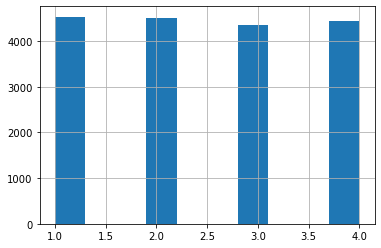

In [34]:
sheet['gScenarios'].hist()

In [35]:
set(sheet.dtypes.tolist())  # datatypes

{dtype('int64'), dtype('float64'), dtype('O')}

In [36]:
sheet.dtypes[sheet.dtypes != 'int64'][sheet.dtypes != 'float64']  # objs

zip    object
dtype: object

### Preprocessing:
* Replace/(Remove) nans with -1:
    * https://arxiv.org/abs/2109.10431 (Fairness without Imputation: A Decision Tree Approach for Fair Prediction with Missing Values)
* Reassign ratings for target variable (binary classification): 1-2 (disagree), 3-5 (agree).

In [37]:
# Replace nans with -1
sheet = SurveyConditioning.substitute_nan(sheet)

In [38]:
# Convert to float
sheet['zip'] = pd.to_numeric(sheet['zip'])  # todo: do this for appropriate columns
print(set(sheet.dtypes.tolist()))  # datatypes

{dtype('int64'), dtype('float64')}


### Channels, groups and targets:

In [39]:
def reassign_target(target_col, df):
    # Reassign ratings for target
    df[target_col] = df[target_col].apply(lambda x: 0 if x <= 2 else 1)
    return df

def divide_group(sheet, group_col):
    gb_groups = sheet.groupby(group_col)
    dfs = {}
    for key, val in gb_groups.groups.items():
        df_ = sheet.iloc[val].reset_index(drop=True)
        dfs[key] = df_
        
    return dfs
    

def get_Xy(df, target, excludes):
    X = df[df.columns[~df.columns.isin([target] + excludes)]]
    y = df.loc[:, [target]]
    return X, y


def topK_features(df, clf, top_k=10):
    # Feature importance
    feat_importance = clf.tree_.compute_feature_importances(normalize=False)

    feat_importances = {}
    for feat, importance in zip(df.columns, clf.feature_importances_):
        feat_importances[feat] = importance

    feat_importances = {k: v for k, v in sorted(feat_importances.items(), key=lambda item: item[1], reverse=True)}

    # Top k feats.
    feat_importances = list(feat_importances.items())[:top_k]
    return feat_importances


def plot_feat_importance(x, y, group):
    fig = plt.figure(figsize = (13, 5))
    plt.bar(x, y, color='maroon', width=0.4)

    plt.xticks(rotation=45)
    plt.xlabel("Feat. Names")
    plt.ylabel("Feat. Importance")
    plt.title(f"Feat. importance for group: {group}")
    plt.show()
    

def plot_bubbles(target_col, feat_importances, group, group_df):
    feat_names_ls = [x[0] for x in feat_importances]
    feat_import_ls = [x[1] for x in feat_importances]
    
    feats = {'feat_names': feat_names_ls,
             'feat_importances': feat_import_ls,
             'color': ['#5A69AF', '#579E65', '#F9C784', '#FC944A', '#F24C00', '#00B825']}
    
    bubble_chart = BubbleChart(area=feats['feat_importances'],
                           bubble_spacing=0.1)

    bubble_chart.collapse()

    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    bubble_chart.plot(ax, feats['feat_names'], feats['color'])
    ax.axis("off")
    ax.relim()
    ax.autoscale_view()
    ax.set_title(f"Feature importances for group: {group}, strata: {group_df}")
    
    feat_questions = [feat_name + ': ' + feat2question_dict[feat_name] for feat_name in feat_names_ls]
    fig.legend(feat_questions, 
               title=f"Features description:\n\nTarget question ({target_col}): {feat2question_dict[target_col]}\n", 
               loc='lower center', bbox_to_anchor=(1,1))


def fit_group(target, group_df, exclude_cols, undersampling=False, seed=42, debug=False):
    # Reassign ratings for target
    df = reassign_target(target, group_df)

    # X, y
    X, y = get_Xy(df, target, exclude_cols)
    if debug:
        display(X.head())
        display(X.shape)
        display(y.head())
        display(y.shape)
    
    # Sampling
    smote = SMOTE(random_state=seed)  # Synthetic Minority Over-sampling TEchnique
    rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)  # resample all classes but the minority class
    sampler = rus if undersampling else smote

    X_sampled, y_sampled = sampler.fit_resample(X, y)
    print('Before splitting:')
    display(y_sampled.value_counts())

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=seed)
    
    print('After splitting:')
    display(y_train.value_counts())
    display(y_test.value_counts())

    # DT
    dt_clf = DecisionTreeClassifier(criterion='gini', random_state=seed)
    dt_clf.fit(X_train, y_train)

    # Evaluation
    plot_confusion_matrix(dt_clf, X_test, y_test)
    y_pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}\n")

    # Feature importance
    num_features = X_sampled.shape[1]
    feat_importances = topK_features(df=X_sampled, clf=dt_clf, top_k=5)

    return feat_importances



Target questions:

* 'Q22_1': 'I control my emotions by not expressing them.',
* 'Q23_1': 'I control my emotions by changing the way I think about the situation I am in.',
* 'Q24_1': 'I think it is important to take warnings about negative outcomes seriously even if the negative outcome will not occur for many years.',
* 'Q26_1': 'I feel guilty if other people do not save energy',
* 'Q29_1': 'I feel proud if other people save energy',
* 'Q30_1': 'I am angry about the fact that many people in do not save energy',
* 'Q31_1': ' The use of more renewable energy sources will benefit the environment.',
* 'Q32_1': 'The use of more renewable energy sources will create new jobs in ',
* 'Q33_1': 'Most scientists say that the world’s temperature has slowly been rising over the past 100 years. Do you think this has been happening?',
* 'Q34': 'Assuming that the world’s temperature is rising, do you think this is caused mostly by natural causes, about equally by natural causes and human activity, or mostly by human activity?

Number of groups: 3
Before splitting:


Q22_1
0        6611
1        6611
dtype: int64

After splitting:


Q22_1
0        5294
1        5283
dtype: int64

Q22_1
1        1328
0        1317
dtype: int64

Accuracy: 0.7251417769376182

Before splitting:


Q22_1
0        5550
1        5550
dtype: int64

After splitting:


Q22_1
0        4474
1        4406
dtype: int64

Q22_1
1        1144
0        1076
dtype: int64

Accuracy: 0.6306306306306306

Number of groups: 4
Before splitting:


Q22_1
0        3111
1        3111
dtype: int64

After splitting:


Q22_1
0        2500
1        2477
dtype: int64

Q22_1
1        634
0        611
dtype: int64

Accuracy: 0.6666666666666666

Before splitting:


Q22_1
0        3122
1        3122
dtype: int64

After splitting:


Q22_1
0        2501
1        2494
dtype: int64

Q22_1
1        628
0        621
dtype: int64

Accuracy: 0.6805444355484388

Before splitting:


Q22_1
0        2978
1        2978
dtype: int64

After splitting:


Q22_1
1        2386
0        2378
dtype: int64

Q22_1
0        600
1        592
dtype: int64

Accuracy: 0.6593959731543624

Before splitting:


Q22_1
0        2953
1        2953
dtype: int64

After splitting:


Q22_1
0        2388
1        2336
dtype: int64

Q22_1
1        617
0        565
dtype: int64

Accuracy: 0.6446700507614214

Number of groups: 5
Before splitting:


Q22_1
0        1348
1        1348
dtype: int64

After splitting:


Q22_1
1        1081
0        1075
dtype: int64

Q22_1
0        273
1        267
dtype: int64

Accuracy: 0.6592592592592592

Before splitting:


Q22_1
0        2034
1        2034
dtype: int64

After splitting:


Q22_1
0        1652
1        1602
dtype: int64

Q22_1
1        432
0        382
dtype: int64

Accuracy: 0.6412776412776413

Before splitting:


Q22_1
0        2731
1        2731
dtype: int64

After splitting:


Q22_1
1        2185
0        2184
dtype: int64

Q22_1
0        547
1        546
dtype: int64

Accuracy: 0.6724611161939615

Before splitting:


Q22_1
0        5798
1        5798
dtype: int64

After splitting:


Q22_1
0        4681
1        4595
dtype: int64

Q22_1
1        1203
0        1117
dtype: int64

Accuracy: 0.6594827586206896

Before splitting:


Q22_1
0        253
1        253
dtype: int64

After splitting:


Q22_1
0        202
1        202
dtype: int64

Q22_1
0        51
1        51
dtype: int64

Accuracy: 0.7058823529411765



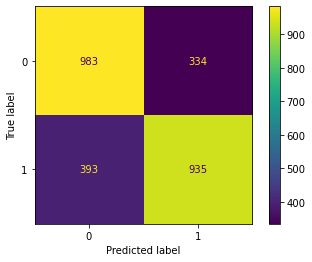

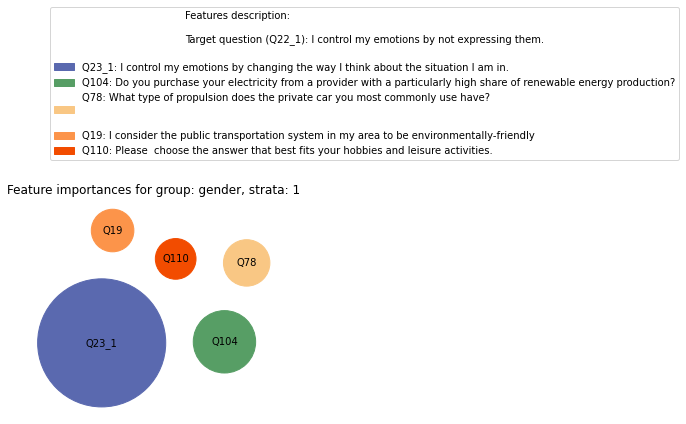

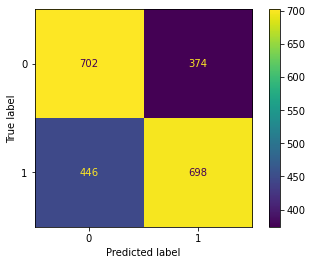

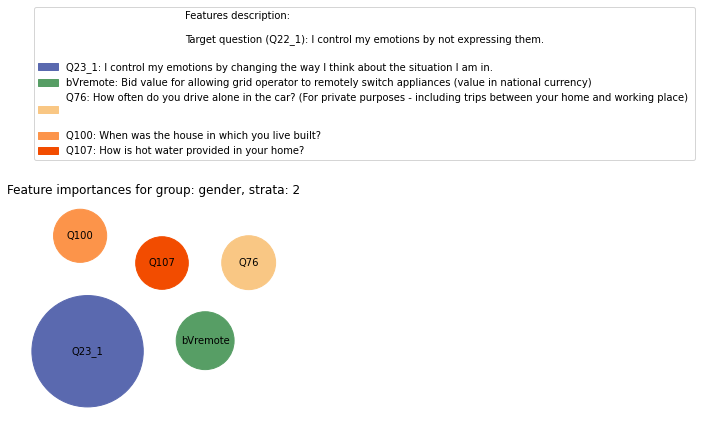

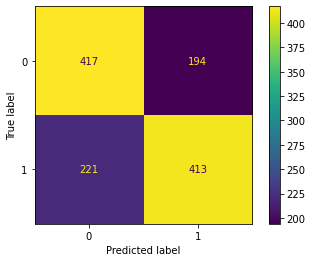

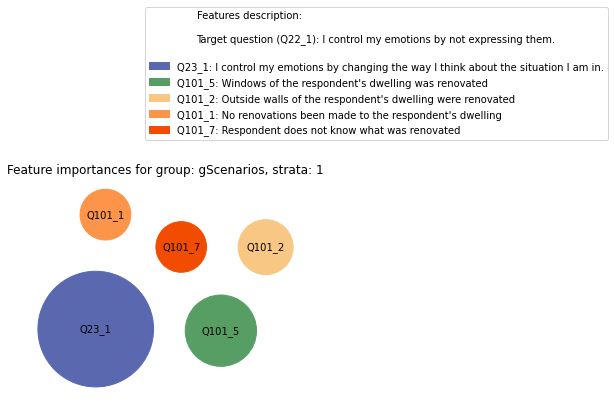

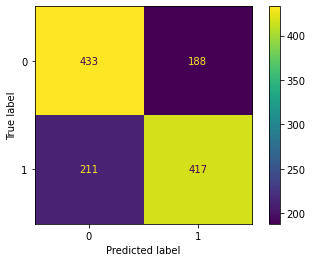

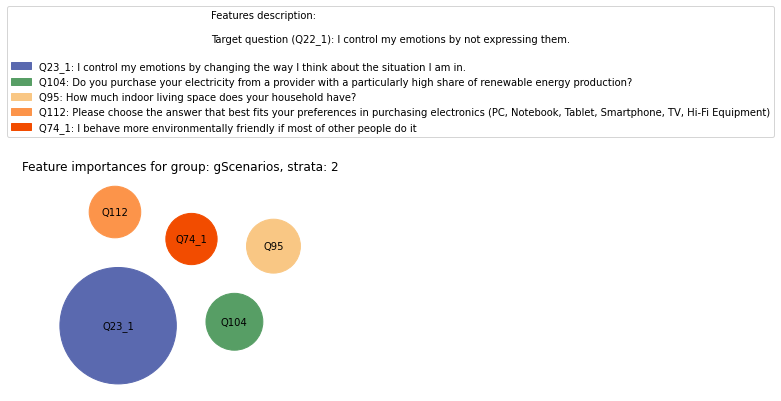

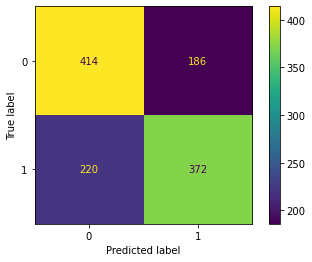

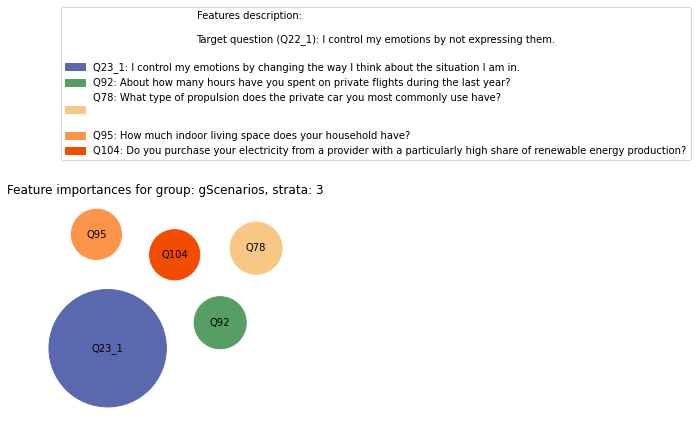

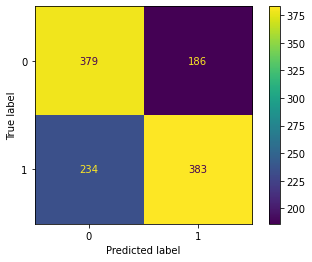

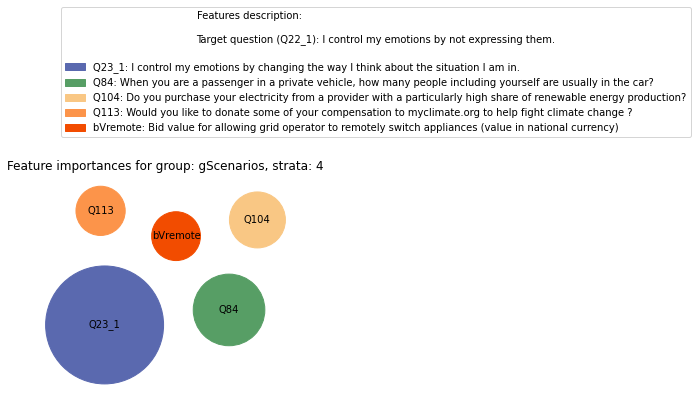

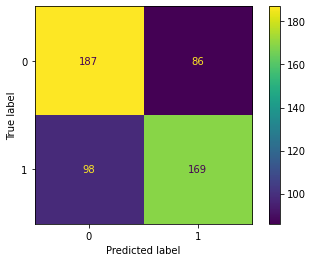

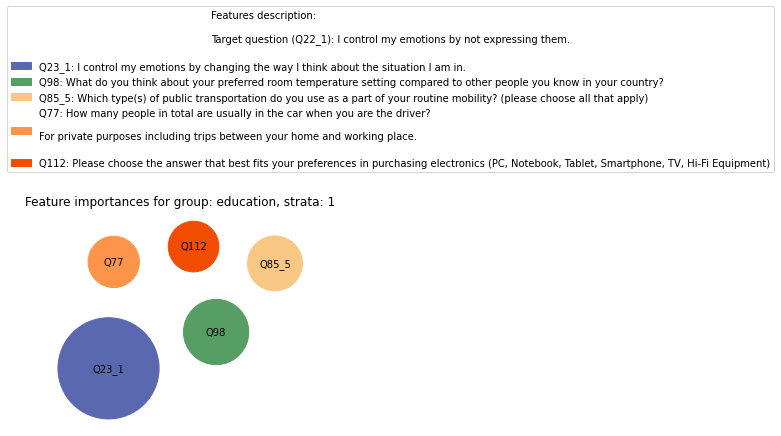

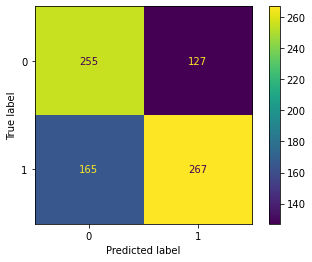

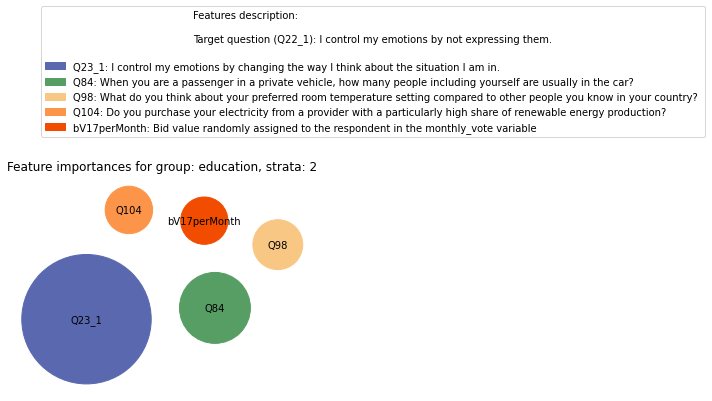

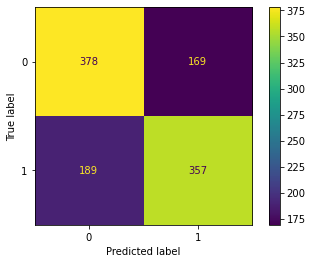

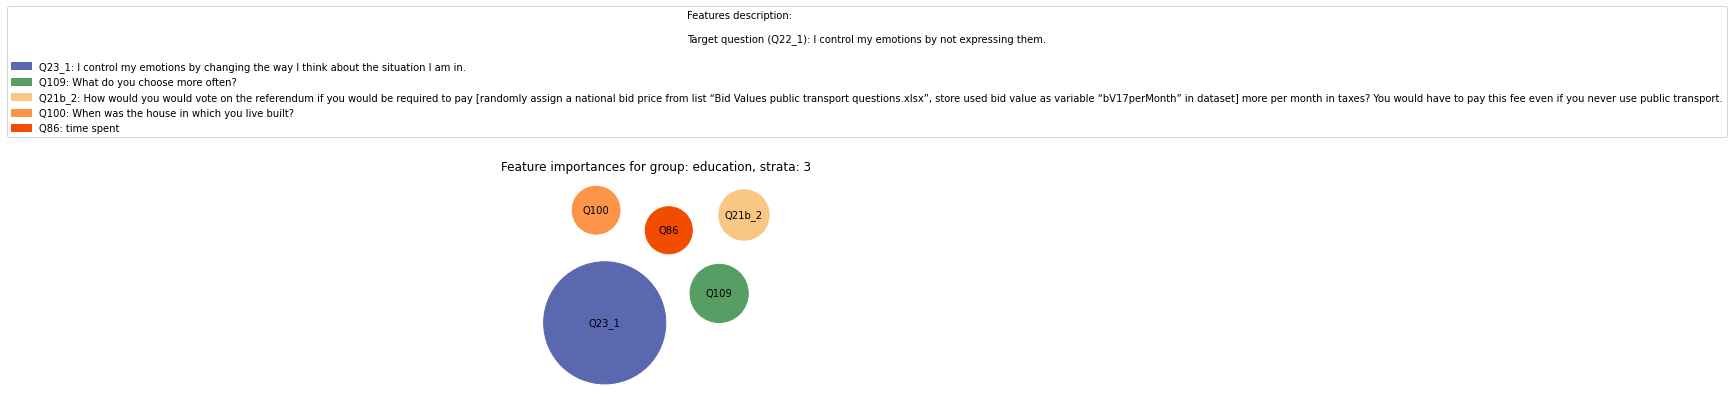

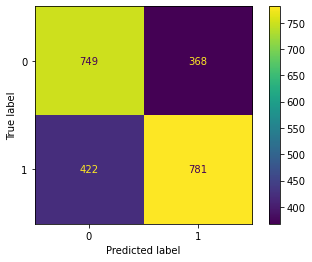

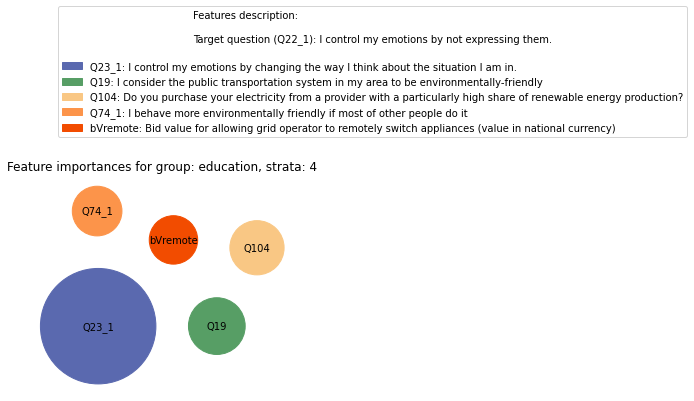

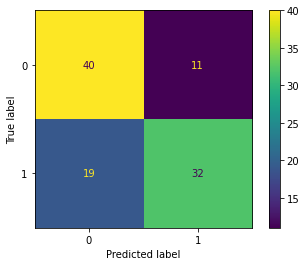

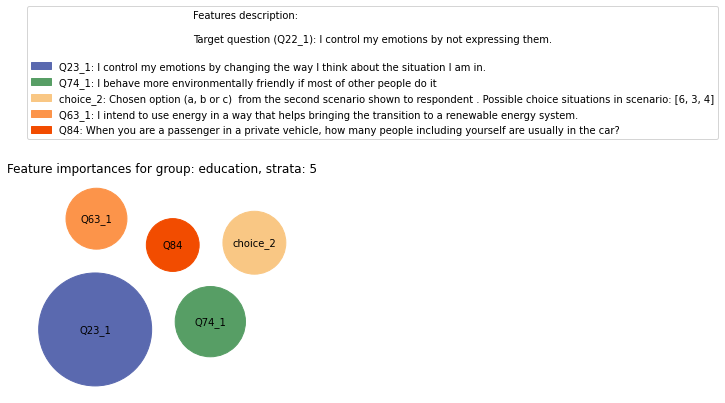

In [40]:
targets = ['Q22_1'] #, 'Q23_1', 'Q24_1', 'Q26_1', 'Q29_1', 'Q30_1', 'Q31_1', 'Q32_1', 'Q33_1', 'Q34']
# groups = ['gScenarios', 'country_sample', 'age', 'gender', 'education', 'social_status']
groups = ['gender', 'gScenarios', 'education']
channels = divide_group(sheet=sheet, group_col='gScenarios')

exclude_cols = demographic_cols
seed = 42

# Loop through treatment groups/channels (4)
# for channel in channels:
    # Loop through channel groups

for group in groups:    
    group_dfs = divide_group(sheet, group)
    # group_dfs = divide_group(channels[channel], group)
    print(f"Number of groups: {len(group_dfs)}")
    
    for group_df in group_dfs:
        if group == 'gender' and group_df == 3:
            continue
            
        # Loop through target variables
        for target in targets:
            # Fit
            feat_importances = fit_group(target, 
                                         group_dfs[group_df],
                                         exclude_cols,
                                         undersampling=False, 
                                         seed=seed, 
                                         debug=False)

            # Plot
            plot_bubbles(target, feat_importances, group, group_df)




### Cross-validation with undersampling:

In [41]:
# Cross-validation and undersampling
'''
def topK_features(df, clf, top_k=10):
    # Feature importance
    feat_importance = clf.tree_.compute_feature_importances(normalize=False)

    feat_importances = {}
    for feat, importance in zip(df.columns, clf.feature_importances_):
        feat_importances[feat] = importance

    feat_importances = {k: v for k, v in sorted(feat_importances.items(), key=lambda item: item[1], reverse=True)}

    # Top k feats.
    feat_importances = list(feat_importances.items())[:top_k]
    return feat_importances


seed = 42
k_folds = 10
undersampling = False  # under or oversampling

smote = SMOTE(random_state=seed)  # Synthetic Minority Over-sampling TEchnique
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)  # resample all classes but the minority class
sampler = rus if undersampling else smote

clf = DecisionTreeClassifier(criterion='gini', random_state=seed)

skf = StratifiedKFold(n_splits=k_folds, random_state=seed, shuffle=True)
X_sampled, y_sampled = sampler.fit_resample(X, y)


features_per_fold = {}
total_features = []

for fold_i, (train_index, test_index) in enumerate(skf.split(X_sampled, y_sampled)):
    print(f"{'#'*6} Fold {fold_i} {'#'*6}")
    X_train, X_test = X_sampled.iloc[train_index], X_sampled.iloc[test_index]
    y_train, y_test = y_sampled.iloc[train_index], y_sampled.iloc[test_index]
    clf.fit(X_train, y_train)
    
    # Evaluation
    plot_confusion_matrix(clf, X_test, y_test)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for all features: {accuracy}\n")
    
    # Feature importance
    num_features = X_sampled.shape[1]
    feat_importances = topK_features(df=X_sampled, clf=clf, top_k=num_features)
    feat_names_ls = [x[0] for x in feat_importances]
    feat_import_ls = [x[1] for x in feat_importances]
    
    # Feature selection
    features_selected = {}
    
    n_dim = range(1, num_features, 1)  # n_dim = reversed(range(10, num_features, 10))
    for dim in n_dim:
        X_train_new = X_train[feat_names_ls[:dim]]
        X_test_new = X_test[feat_names_ls[:dim]]
        
        # Retrain with new selected features
        clf.fit(X_train_new, y_train)
        
        # Reevaluate
        y_pred = clf.predict(X_test_new)
        accuracy2 = accuracy_score(y_test, y_pred)
        print(f"Top {dim} features. Reevaluated accuracy {accuracy2}")

        if accuracy2 > 0.8:
            features_selected[dim] = feat_names_ls[:dim]
            features_per_fold[fold_i] = feat_names_ls[:dim]
            total_features.extend(feat_names_ls[:dim])
            break
    
    print(f"\nfeatures_selected: {features_selected}\n")
    # Plot histogram of features: num of times each feature occurs
'''

'\ndef topK_features(df, clf, top_k=10):\n    # Feature importance\n    feat_importance = clf.tree_.compute_feature_importances(normalize=False)\n\n    feat_importances = {}\n    for feat, importance in zip(df.columns, clf.feature_importances_):\n        feat_importances[feat] = importance\n\n    feat_importances = {k: v for k, v in sorted(feat_importances.items(), key=lambda item: item[1], reverse=True)}\n\n    # Top k feats.\n    feat_importances = list(feat_importances.items())[:top_k]\n    return feat_importances\n\n\nseed = 42\nk_folds = 10\nundersampling = False  # under or oversampling\n\nsmote = SMOTE(random_state=seed)  # Synthetic Minority Over-sampling TEchnique\nrus = RandomUnderSampler(sampling_strategy=\'not minority\', random_state=seed)  # resample all classes but the minority class\nsampler = rus if undersampling else smote\n\nclf = DecisionTreeClassifier(criterion=\'gini\', random_state=seed)\n\nskf = StratifiedKFold(n_splits=k_folds, random_state=seed, shuffle=True)\

In [42]:
# Plot occurences of features from cross-validation
'''
from collections import Counter
counter = Counter(total_features)
print(counter)

labels, values = zip(*counter.items())
plt.bar(labels, values)
plt.xticks(rotation=40)
plt.xlabel("Feature Name")
plt.ylabel("Occurence"
'''

'\nfrom collections import Counter\ncounter = Counter(total_features)\nprint(counter)\n\nlabels, values = zip(*counter.items())\nplt.bar(labels, values)\nplt.xticks(rotation=40)\nplt.xlabel("Feature Name")\nplt.ylabel("Occurence"\n'